In [220]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Game Theory

## Convexity

In [ ]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty
from helpers.nucleolus.nucleolus import get_nucleolus

In [223]:
def add_shapely_nbs(df: pd.DataFrame, players: list,
                    add_LOO=False, add_nucleolus=True) -> pd.DataFrame:
    """
    Add shapely and nbs values to dataframe df, and optionally LOO and nucleolus.

    df: Dataframe with values for each coalition
    players: list of players
    """
    new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs']))
    if add_LOO:
        new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo']))
        if add_nucleolus:
            new_index = pd.MultiIndex.from_product((df.index, ['value', 'shapley', 'nbs', 'loo', '0. nucleolus']))
    df_new = pd.DataFrame(pd.NA, index=new_index, columns=df.columns)
    for idx, row in df.iterrows():
        df_new.loc[(idx, 'value')] = row
        v = {frozenset(k): val for k, val in row.items()}
        shapley, nbs = get_shapley_value(v, players), get_nash_bargaining_solution(v, players)
        df_new.loc[(idx, 'shapley'), list((k,) for k in shapley.keys())] = list(shapley.values())
        df_new.loc[(idx, 'nbs'), list((k,) for k in nbs.keys())] = list(nbs.values())
        if add_LOO:
            loo = get_loo(v, players)
            df_new.loc[(idx, 'loo'), list((k,) for k in loo.keys())] = list(loo.values())
        if add_nucleolus:
            try:
                nucleolus = get_nucleolus(v, players)
                df_new.loc[(idx, '0. nucleolus'), list((k,) for k in nucleolus.keys())] = list(nucleolus.values())
            except Exception as e:
                print(f"Error computing nucleolus for {idx}: {e}")
                # remove the nucleolus row
                # df_new = df_new.drop(index=(idx, 'nucleolus'))
    return df_new

In [224]:
def print_2f_dict(d: dict):
    final_print = ''
    for k, v in d.items():
        final_print += f"{k}: {v:.2f}, "
    return final_print

In [225]:
players = ['A', 'B', 'C']
v = {
    (): 0,
    ('A',): 0,
    ('B',): 0,
    ('C',): 0,
    ('A', 'B'): 100,
    ('A', 'C'): 0,
    ('B', 'C'): 0,
    ('A', 'B', 'C'): 200
}
# convert v to frozenset
v_frozen = {frozenset(k): val for k, val in v.items()}

In [226]:
# test
is_convex_game(v_frozen, players)
core_nonempty(v_frozen, players)
print("LOO: ", get_loo(v_frozen, players, normalized=False))
print("Shapley: ", print_2f_dict(get_shapley_value(v_frozen, players)))
print("NBS :", print_2f_dict(get_nash_bargaining_solution(v_frozen, players)))
print("Banzhaf: ", print_2f_dict(get_banzhaf_value(v_frozen, players)))
print("Nucleolus: ", print_2f_dict(get_nucleolus(v_frozen, players)))

Core is non-empty, one feasible allocation: [200.   0.   0.]
LOO:  {'A': 200, 'B': 200, 'C': 100}
Shapley:  A: 83.33, B: 83.33, C: 33.33, 
NBS : A: 66.67, B: 66.67, C: 66.67, 
Banzhaf:  A: 85.71, B: 85.71, C: 28.57, 
Nucleolus:  A: 75.00, B: 75.00, C: 50.00, 


## Define Plot Function

In [227]:
import matplotlib as mpl

In [228]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [229]:
def visualize_value_results(df_new, df_newstat, calc_convexity=True):
    players = list(str(x[0]) for x in df_new.columns[:3])
    # plot for each service value, shapely and nbs
    for service in df_new.index.get_level_values(0).unique():
        df_plot = df_new.loc[service]
        # drop index rows that are all NaN
        df_plot = df_plot.dropna(axis=0, how='all')
        df_plot = df_plot.transpose()
        df_plot.columns = [col + ' Dynamic PF' for col in df_plot.columns]
        # also add df_newstat values
        if df_newstat is not None:
            df_plot_stat = df_newstat.loc[service]
            df_plot_stat = df_plot_stat.dropna(axis=0, how='all')
            df_plot_stat = df_plot_stat.transpose()
            # remove value column as it is duplicate
            # df_plot_stat = df_plot_stat.loc[:, df_plot_stat.columns != 'value']
            df_plot_stat.columns = [col + ' Static PF' for col in df_plot_stat.columns]
            # combine
            df_plot_total = pd.concat([df_plot, df_plot_stat], axis=1)
        else:
            df_plot_total = df_plot
        df_plot_total = df_plot_total.reindex(sorted(df_plot_total.columns, reverse=True), axis=1)
        # 1st plot: only the players
        df_plot = df_plot_total.iloc[:len(players)]

        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Individual Value, Shapley and NBS', ylabel='Value in €')
        
        plt.grid()
        plt.ylim(df_plot.min().min(), df_plot.max().max()+3)
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.show()

        # 2nd plot: all coalitions
        plt.figure()
        # drop na columns
        df_plot = df_plot_total.dropna(axis=1, how='any')
        # add two new index rows: Grand-C Convex Game? and Convex Game?

        # add convexity where there is  empty coalition
        if calc_convexity:
            v1 = {frozenset(k): val for k, val in df_new.loc[service].loc['value'].items()}
            v1[frozenset()] = 0  # ensure empty coalition is present
            v2 = {frozenset(k): val for k, val in df_newstat.loc[service].loc['value'].items()}
            v2[frozenset()] = 0  # ensure empty coalition is present
            # create df and append
            df_plot = pd.concat([df_plot, pd.DataFrame(0, index=['Core non-empty?', 'Convex Game?'], columns=df_plot.columns)], axis=0)
            df_plot.loc['Core non-empty?', 'value Dynamic PF'] = float(core_nonempty(v1, players))
            df_plot.loc['Core non-empty?', 'value Static PF'] = float(core_nonempty(v2, players))
            # calculate total convexity
            df_plot.loc['Convex Game?', 'value Dynamic PF'] = float(is_convex_game(v1, players))
            df_plot.loc['Convex Game?', 'value Static PF'] = float(is_convex_game(v2, players))
        
        
        ax = df_plot.plot(kind='bar', figsize=(10, 6),
                        title=f'Service: {service} - Value of Coalitions', ylabel='Value in €')
        plt.grid()
        plt.xticks(rotation=0)
        # show numbers above bars
        for p in ax.patches:
            if p.get_height() >= 0:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, 1.03 * p.get_height()),
                            ha='center', va='bottom', rotation=90, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, df_plot.max().max()+3)
        plt.show()


## DVPP1

no stochastic production, just 1MW of PV, Wind, BESS each

**IO_dict =      {'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }**

In [230]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v1/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = list(str(x[0]) for x in df.columns[:3])

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,23.35187,12.37032,12.37032,24.74064
FFR,1.13156,0.89878,3.16838,1.91396,3.05199,3.05199,5.05647
FFR-FCR,4.73210,3.80625,0.00000,7.61250,11.67593,11.90740,20.11141
FCR-D,12.60178,12.60178,0.00000,25.20356,12.60178,12.60178,25.20356


In [231]:
# also load static pf values
dfstat = pd.read_csv('pics/v1/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,12.37032,12.13886,0.00000,24.27771,6.12086,6.12086,16.40803
FFR,1.13156,0.89878,3.16838,2.03035,2.76101,2.47004,4.12535
FFR-FCR,4.73210,3.80625,0.00000,8.53835,6.12086,6.12086,16.40803
FCR-D,12.60178,12.60178,0.00000,25.20356,7.27817,7.27817,19.18557


In [232]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstat, players, add_LOO=True)

Error computing nucleolus for FFR: Model is infeasible
Error computing nucleolus for FCR: Model is infeasible
Error computing nucleolus for FFR: Model is infeasible
Error computing nucleolus for FCR-D: Model is infeasible


In [233]:
df_v1 = df_new.copy()
df_v1stat = df_newstat.copy()

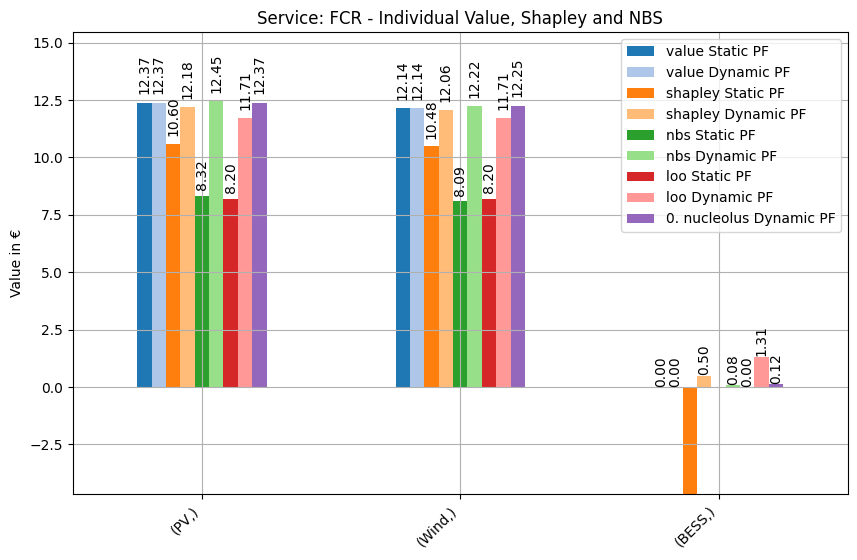

Core is non-empty, one feasible allocation: [12.37032 12.37032  0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

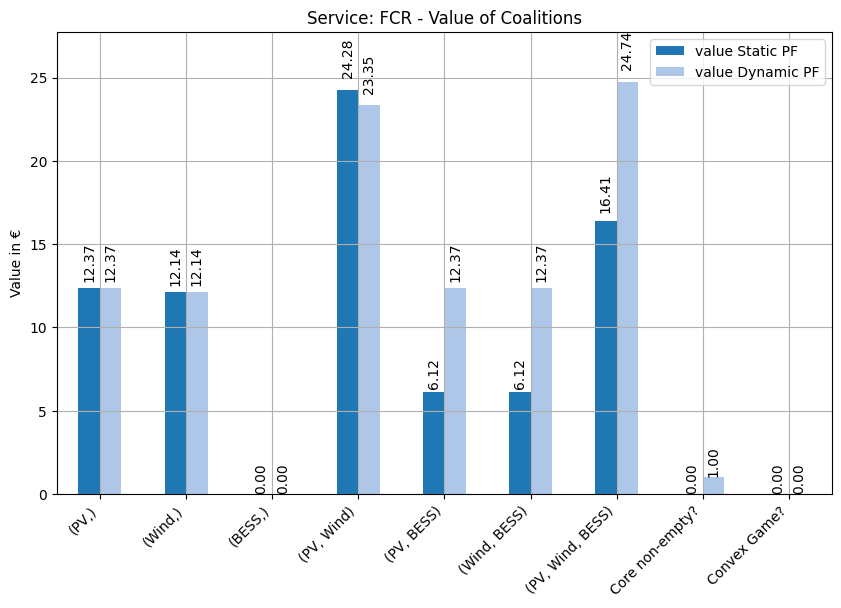

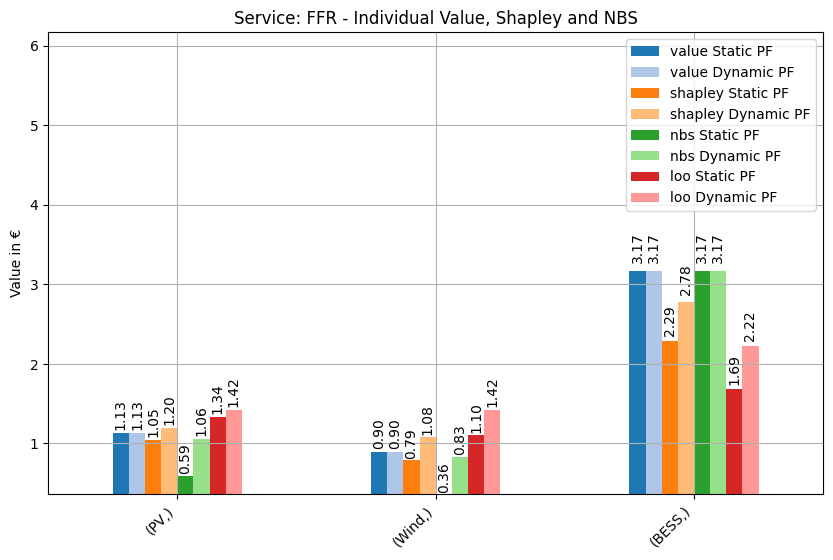

Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

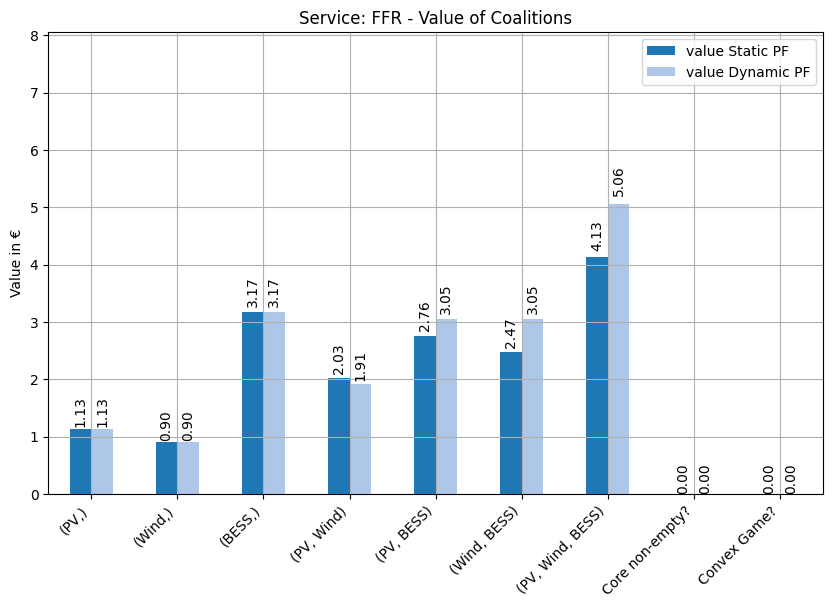

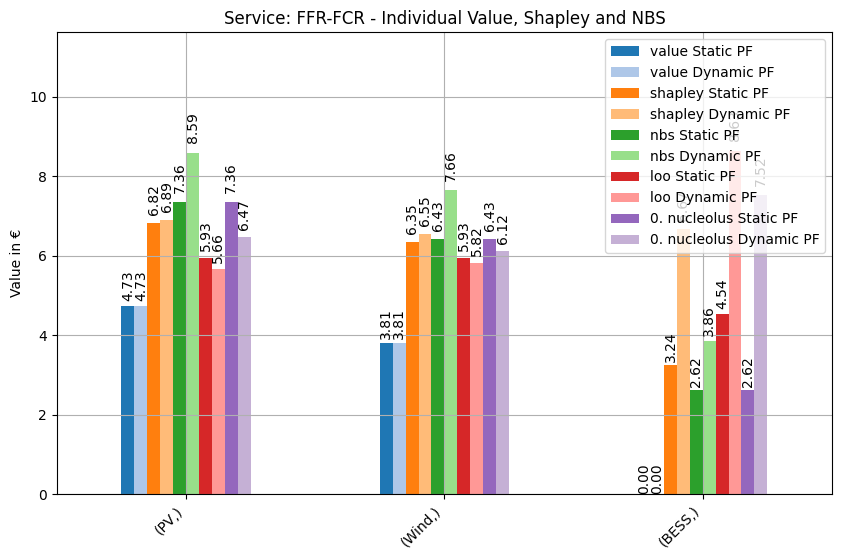

Core is non-empty, one feasible allocation: [8.20401 8.43548 3.47192]
Core is non-empty, one feasible allocation: [10.28717  6.12086  0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

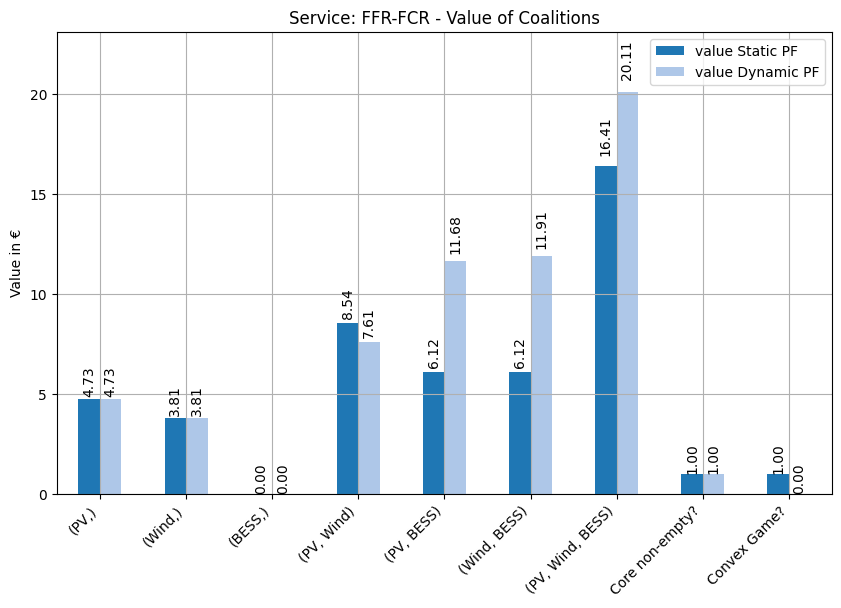

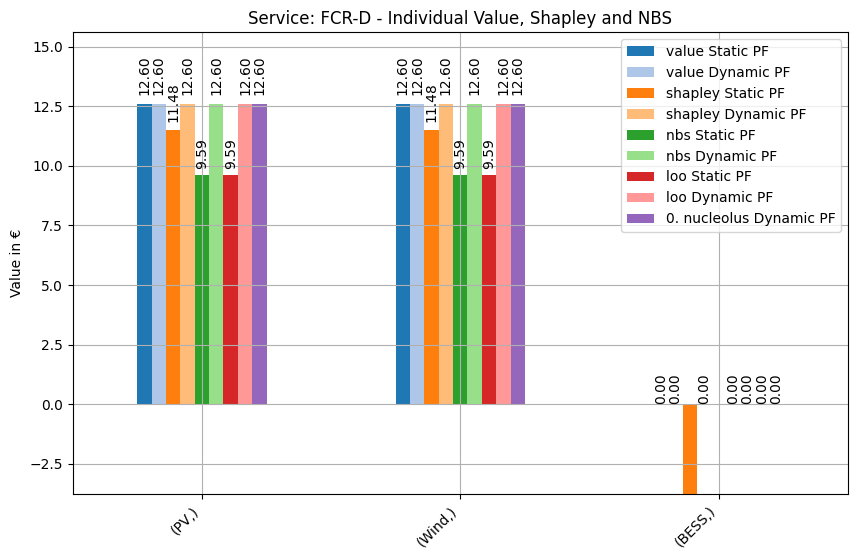

Core is non-empty, one feasible allocation: [12.60178 12.60178  0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

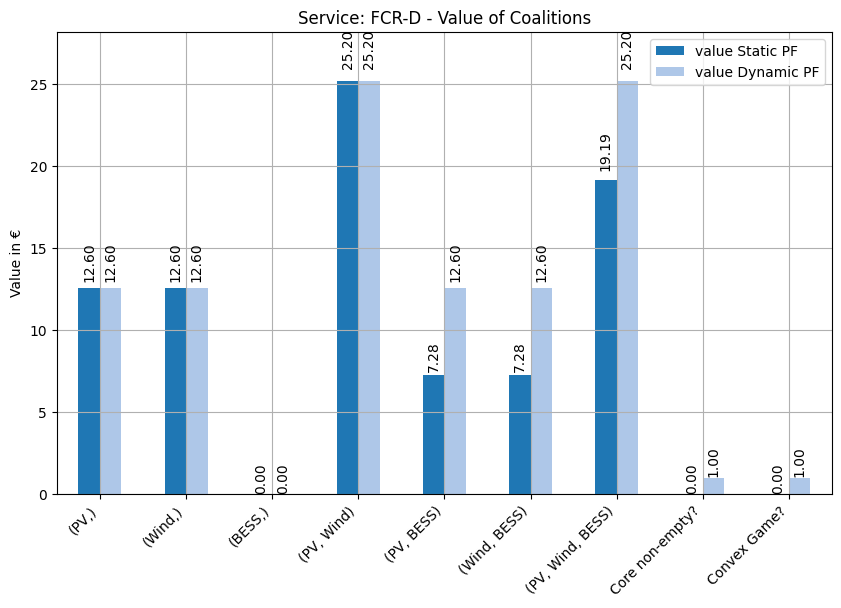

In [234]:
visualize_value_results(df_new, df_newstat)

## DVPP2

stochastic production of PV, BESS Wind with 

IO_dict =      {'PV': (get_pv_sys(), 'lpf', 2),
                'Wind': (get_wind_sys(), 'lpf', 1.5),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }

In [235]:
# load data
# df = pd.read_csv('pics/new/values.csv', index_col=0, header=[0,1,2])
df = pd.read_csv('pics/v2/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
df.index = pd.MultiIndex.from_arrays([df.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
df.drop(df.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in df.columns[:3])
df.head()

df_mean = df.groupby('Service').mean()

In [236]:
# also load static pf values
dfstat = pd.read_csv('pics/v2/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players = list(dfstat.columns[-2])
dfstat[dfstat < 0] = 0  # set values below zero to zero
# combine 1st col and index to MultiIndex
dfstat.index = pd.MultiIndex.from_arrays([dfstat.index, df.iloc[:, 0]], names=['Service', 'Scenario'])
dfstat.drop(dfstat.columns[0], axis=1, inplace=True)  # drop first column
players = list(str(x[0]) for x in dfstat.columns[:3])

dfstst_mean = dfstat.groupby(level=0).mean()

In [237]:
df_new = add_shapely_nbs(df_mean, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstst_mean, players, add_LOO=True)

Error computing nucleolus for FCR-D: Model is infeasible
Error computing nucleolus for FFR: Model is infeasible
Error computing nucleolus for FCR: Model is infeasible
Error computing nucleolus for FCR-D: Model is infeasible
Error computing nucleolus for FFR: Model is infeasible


In [238]:
df_v2 = df_new.copy()
df_v2stat = df_newstat.copy()

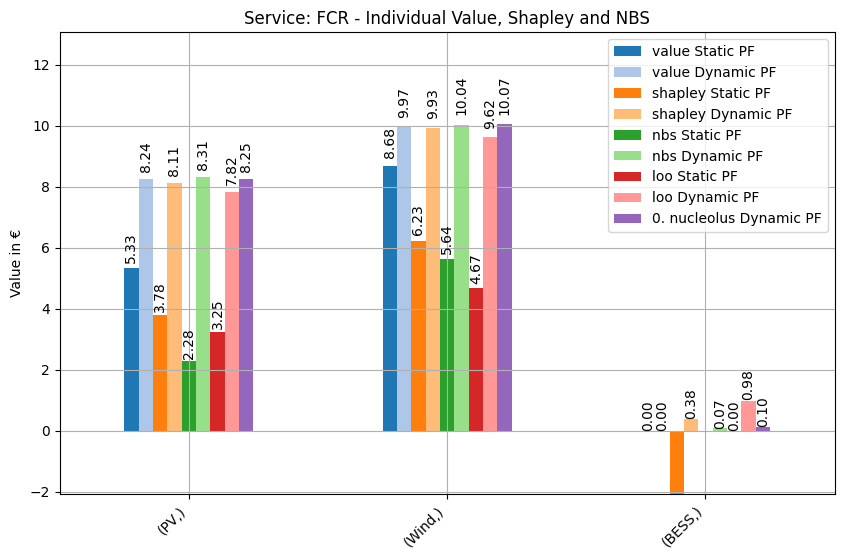

Core is non-empty, one feasible allocation: [ 8.26254667 10.15883467  0.        ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

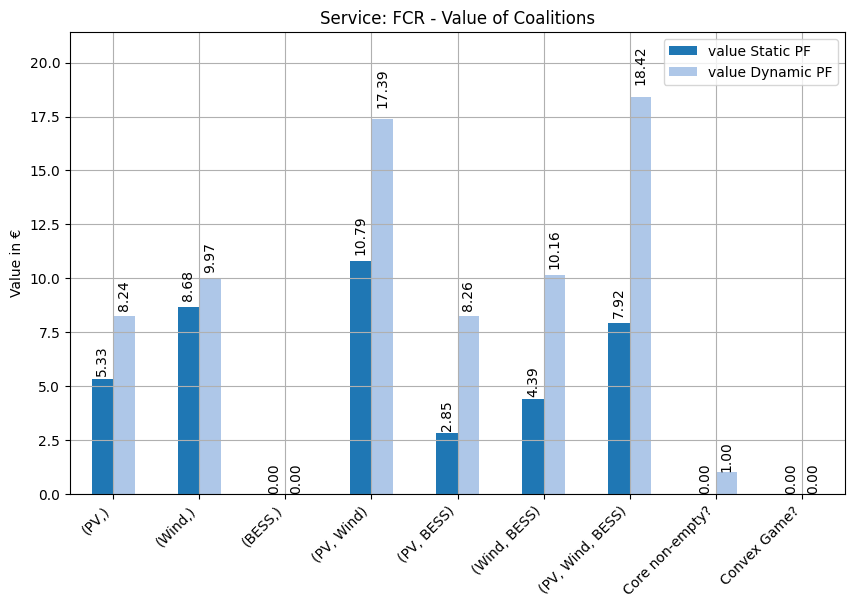

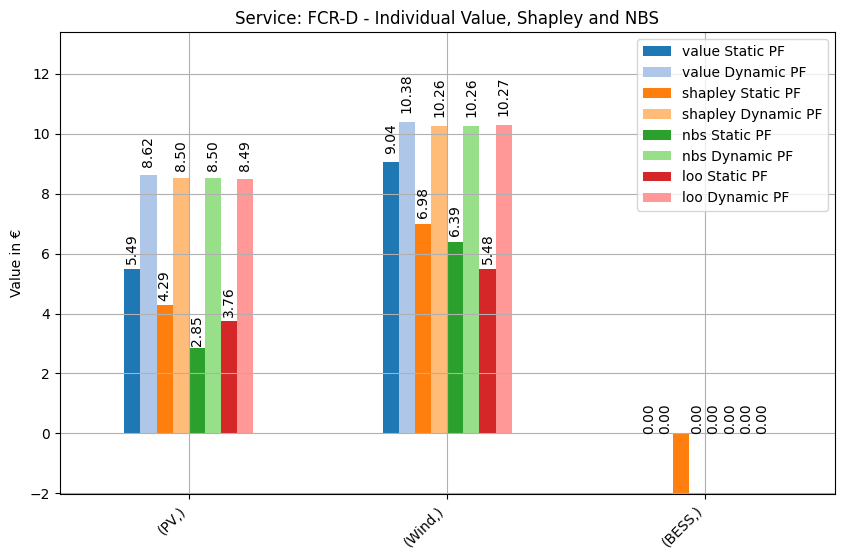

Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

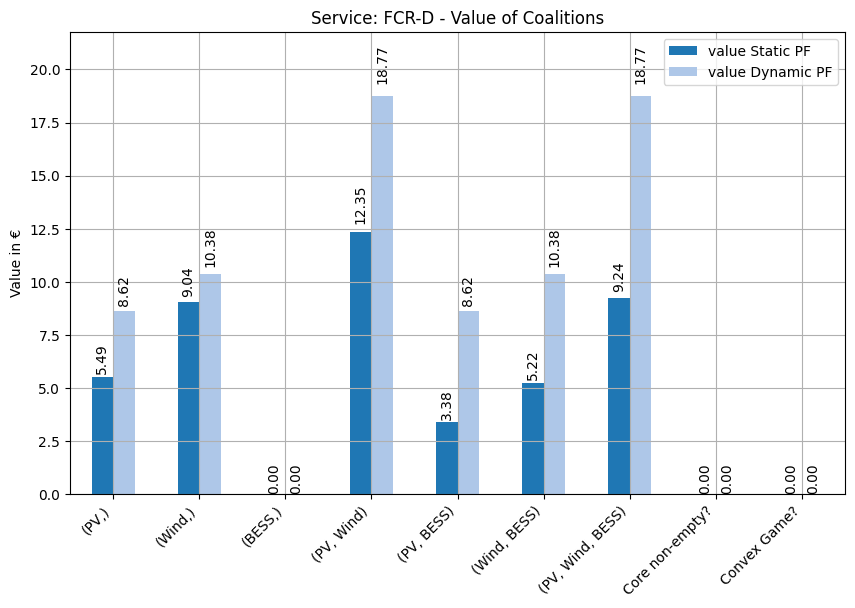

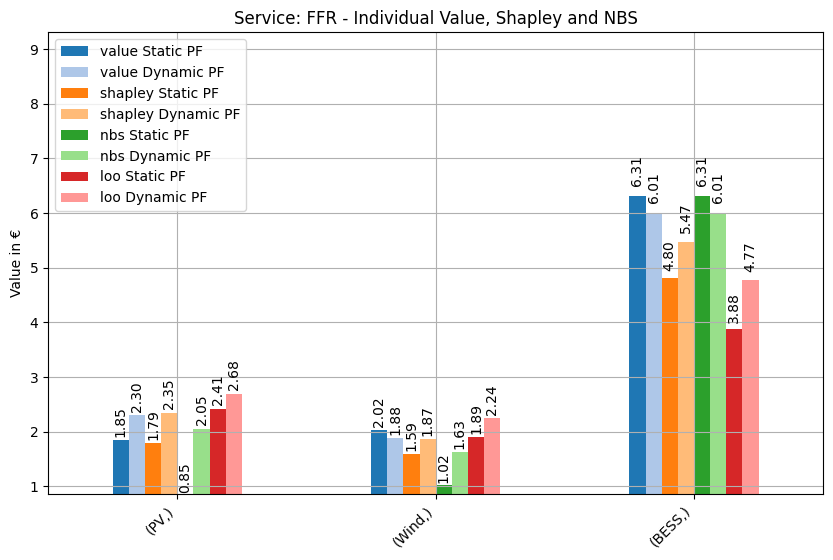

Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

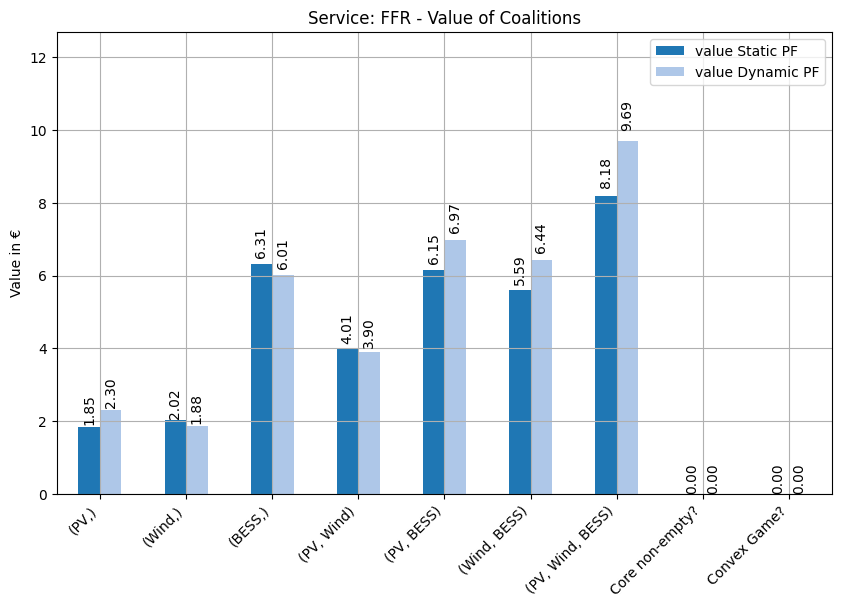

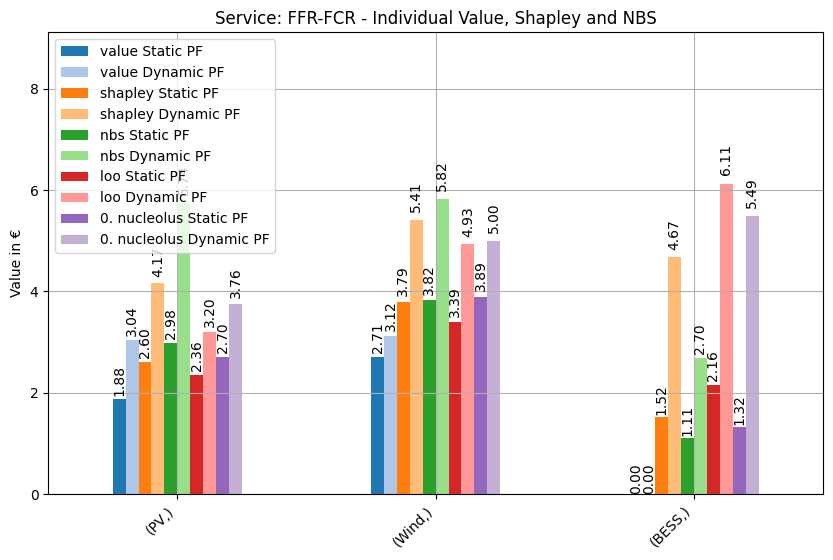

Core is non-empty, one feasible allocation: [4.46985133 6.87525533 2.90228733]
Core is non-empty, one feasible allocation: [3.52817133 4.38925933 0.        ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

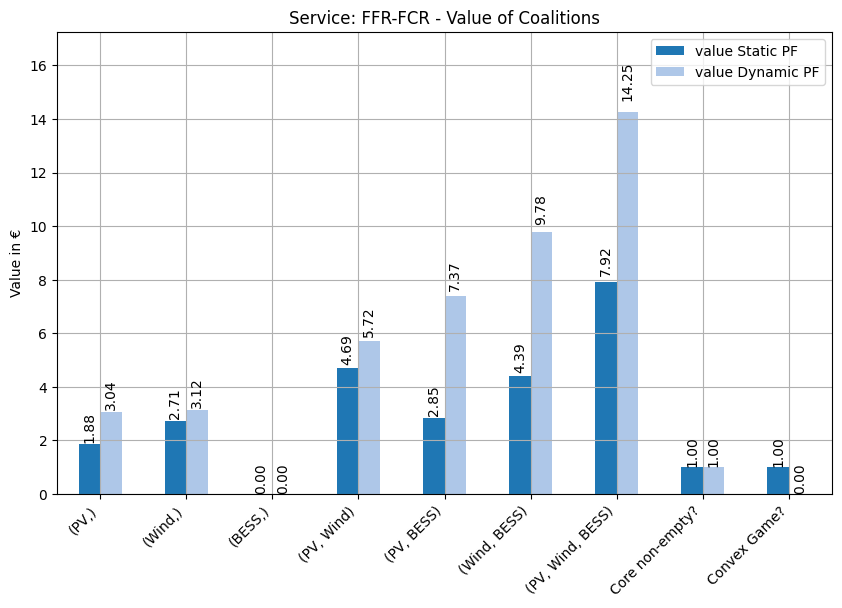

In [239]:
# visualize:
visualize_value_results(df_new, df_newstat)

## DVPP3

no stochastic production, 1MW of

**IO_dict = {'Hydro': (get_hydro_tf(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                'SC': (get_sc_io_sys(t_drop=5), 'hpf', 1),
                }**

In [240]:
# load data
df = pd.read_csv('pics/v3/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
players = [str(x[0]) for x in df.columns[:3]]
df[df < 0] = 0  # set values below zero to zero
df

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,12.37032,1.26018,0.00000,12.37032
FFR,0.0,3.16838,0.84059,2.99379,1.48073,3.16838,2.99379
FFR-FCR,0.0,0.00000,0.00000,6.58379,3.34333,0.00000,6.58379
FCR-D,0.0,0.00000,0.00000,7.50963,2.41748,0.00000,7.50963


In [241]:
# also load static pf values
dfstat = pd.read_csv('pics/v3/values_stat.csv', index_col=0, header=[0,1,2])
dfstat.columns = [tuple(c for c in col if c!='nan') for col in dfstat.columns.values]
players_stat = players
dfstat[dfstat < 0] = 0  # set values below zero to zero
dfstat

,"(Hydro,)","(BESS,)","(SC,)","(Hydro, BESS)","(Hydro, SC)","(BESS, SC)","(Hydro, BESS, SC)"
FCR,0.0,0.00000,0.00000,12.37032,6.12086,6.12086,8.20402
FFR,0.0,3.16838,0.84059,1.24795,1.24795,2.41185,1.88809
FFR-FCR,0.0,0.00000,0.00000,5.19502,3.80625,6.12086,7.04671
FCR-D,0.0,0.00000,0.00000,12.60178,7.04671,7.27817,9.59278


In [242]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(dfstat, players, add_LOO=True)

Error computing nucleolus for FFR: Model is infeasible
Error computing nucleolus for FFR: Model is infeasible


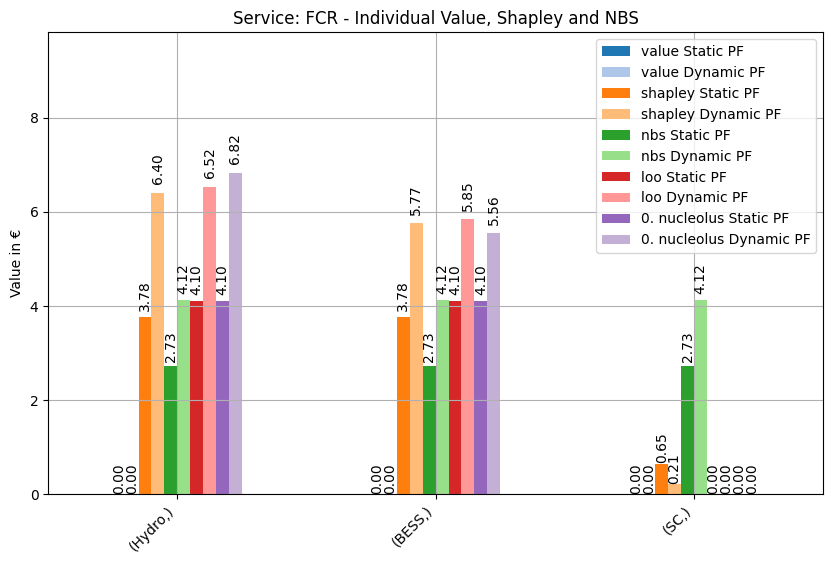

Core is non-empty, one feasible allocation: [12.37032  0.       0.     ]
Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'Hydro', 'SC'})
Game is not convex: frozenset({'SC'}), frozenset({'BESS', 'Hydro'})


<Figure size 640x480 with 0 Axes>

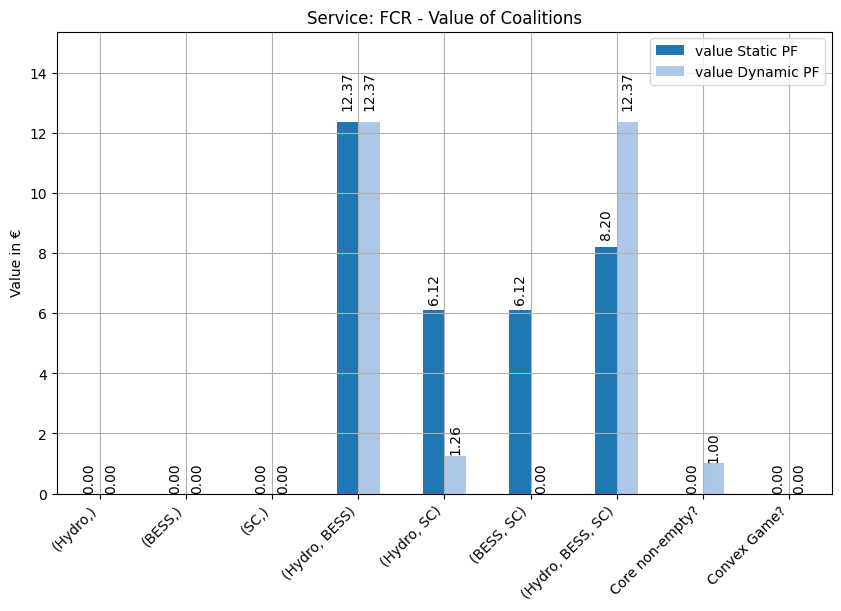

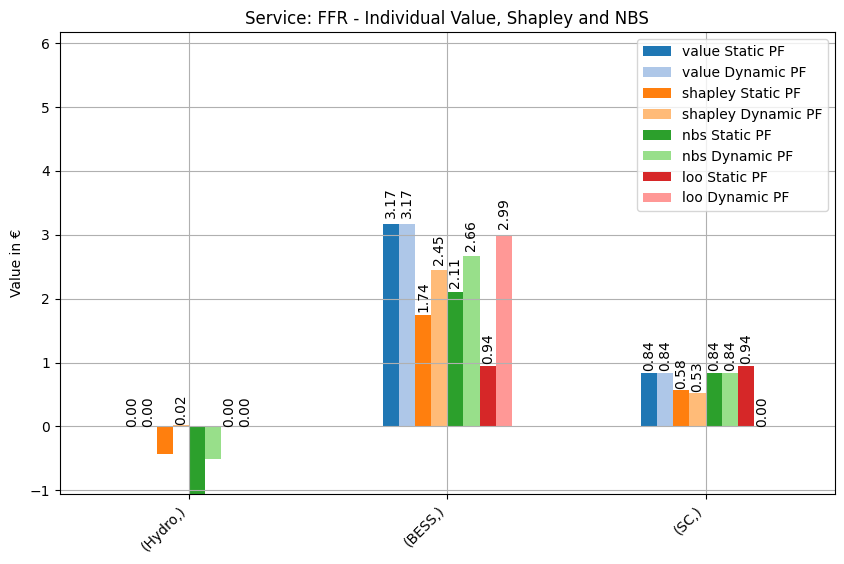

Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})
Game is not convex: frozenset({'Hydro'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

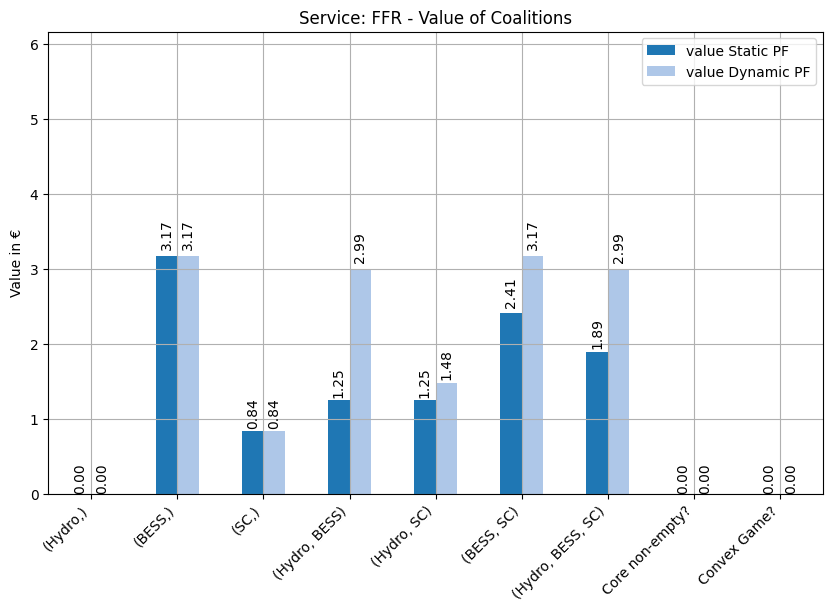

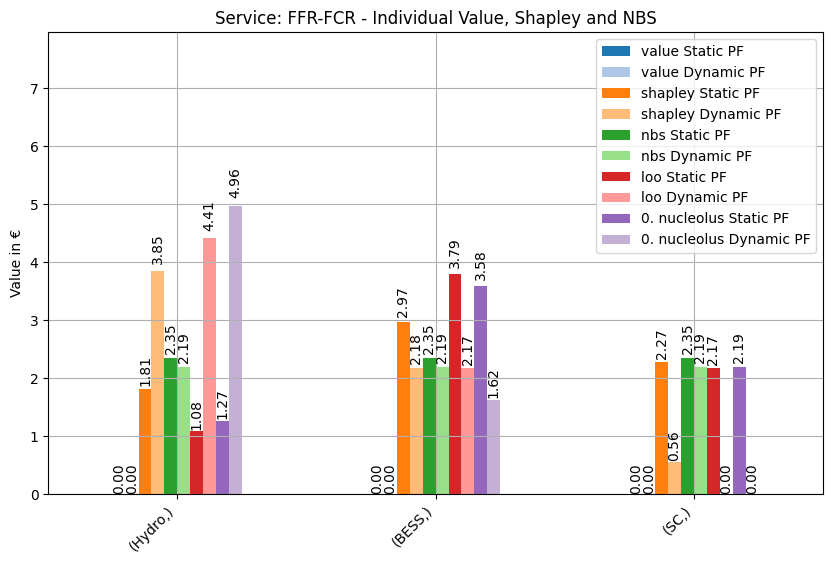

Core is non-empty, one feasible allocation: [6.58379 0.      0.     ]
Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'Hydro', 'SC'})
Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'Hydro', 'SC'})


<Figure size 640x480 with 0 Axes>

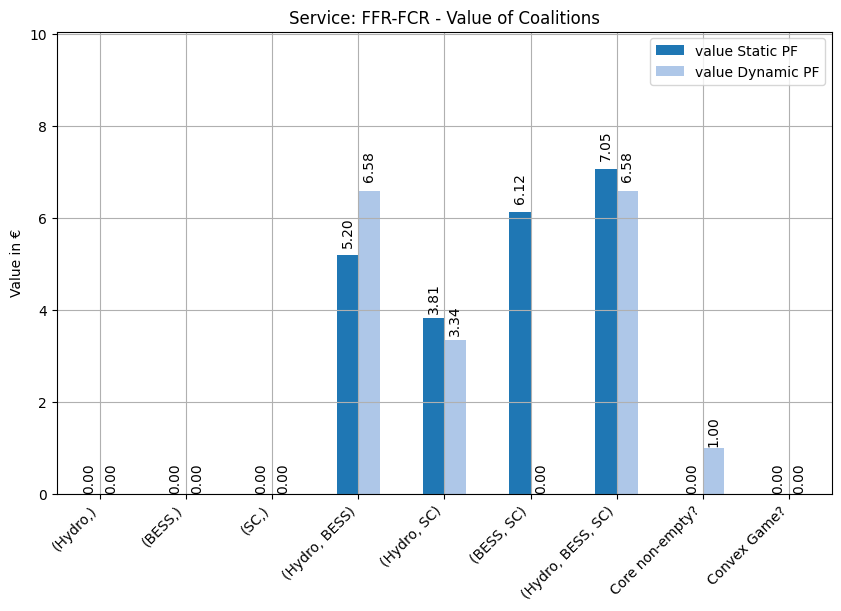

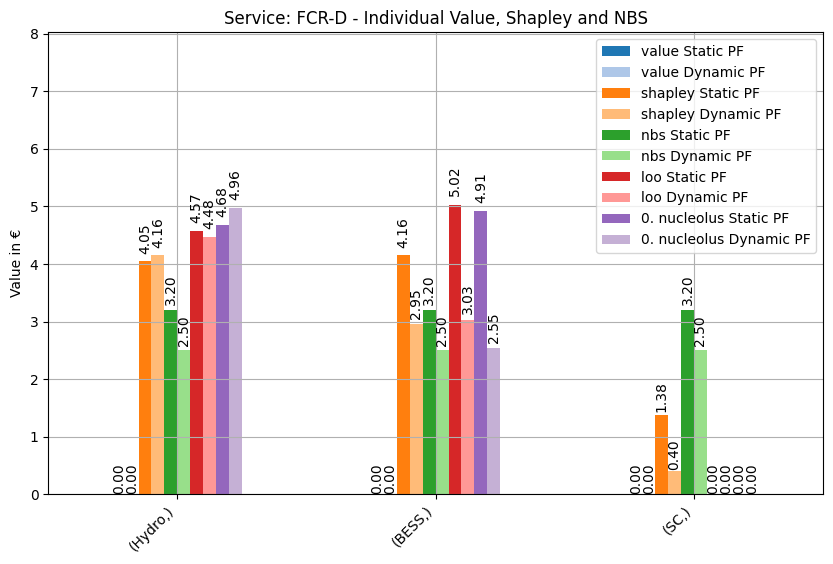

Core is non-empty, one feasible allocation: [7.50963 0.      0.     ]
Game is not convex: frozenset({'BESS', 'Hydro'}), frozenset({'Hydro', 'SC'})
Game is not convex: frozenset({'SC'}), frozenset({'BESS', 'Hydro'})


<Figure size 640x480 with 0 Axes>

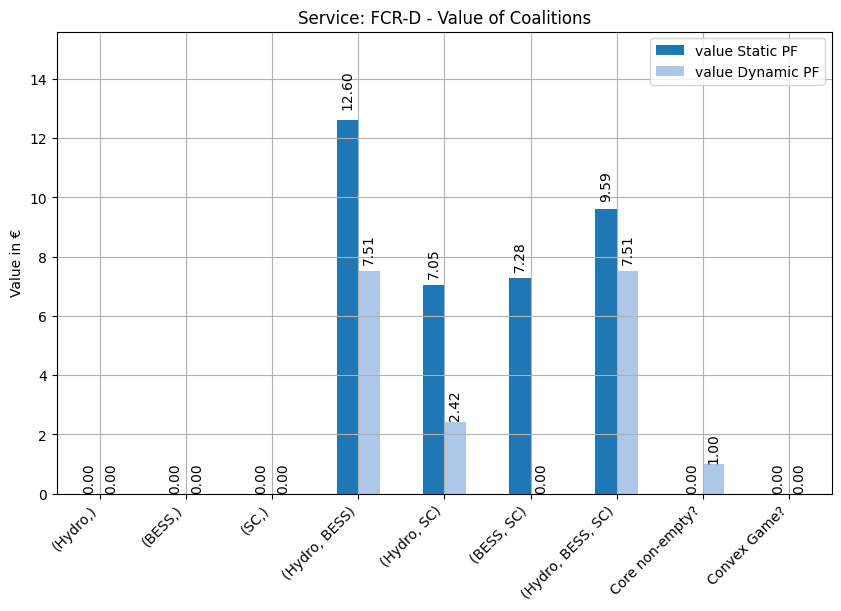

In [243]:
visualize_value_results(df_new, df_newstat)

## DVPP2A

Using adpative dynamic PF (ADPF) with setttings 

{'PV': (get_pv_sys(), 'lpf', 1),
                'Wind': (get_wind_sys(), 'lpf', 1),
                'BESS': (get_bess_energy_sys(e_max=1.8), 'hpf', 1),
                }
    
def adaptive_pv_func(t):
    return .3 + .7 * np.sin(t / 5)**2

def adaptive_wind_func(t):
    return .3 + .7 * np.cos(t / 5 + .5)**2

In [244]:
# load data
df = pd.read_csv('pics/v2A/values_dyn.csv', index_col=0, header=[0,1,2])
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]

df[df < 0] = 0  # set values below zero to zero
df

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,3.57479,3.57479,0.00000,11.31588,12.13886,11.67593,17.79680
FFR,1.01517,0.89878,3.16838,1.09923,3.11018,3.11018,4.24174
FFR-FCR,3.57479,3.57479,0.00000,4.37205,12.13886,3.57479,16.87095
FCR-D,4.26917,4.26917,0.00000,14.09342,5.19502,4.26917,21.03726


In [245]:
df_stat = pd.read_csv('pics/v2A/values_stat.csv', index_col=0, header=[0,1,2])
df_stat.columns = [tuple(c for c in col if c!='nan') for col in df_stat.columns.values]

df_stat[df_stat < 0] = 0  # set values below zero to zero
df_stat

,"(PV,)","(Wind,)","(BESS,)","(PV, Wind)","(PV, BESS)","(Wind, BESS)","(PV, Wind, BESS)"
FCR,3.57479,3.57479,0.00000,11.31588,3.11187,1.72310,8.07543
FFR,1.01517,0.89878,3.16838,1.09923,1.71351,1.94629,2.72868
FFR-FCR,3.57479,3.57479,0.00000,4.37205,1.72310,1.72310,8.07543
FCR-D,4.26917,4.26917,0.00000,14.09342,2.18602,2.18602,9.00127


In [246]:
players = list(str(x[0]) for x in df.columns[:3])

In [247]:
df_new = add_shapely_nbs(df, players, add_LOO=True)
df_newstat = add_shapely_nbs(df_stat, players, add_LOO=True)

Error computing nucleolus for FFR: Model is infeasible
Error computing nucleolus for FFR: Model is infeasible


In [248]:
df_v2A = df_new.copy()
df_v2Astat = df_newstat.copy()

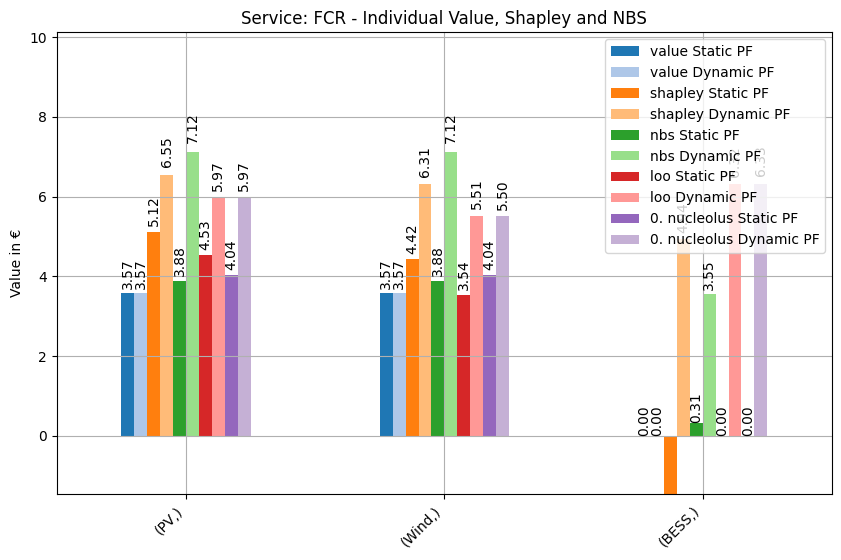

Core is non-empty, one feasible allocation: [6.12087 5.65794 6.01799]
Game is not convex: frozenset({'PV', 'Wind'}), frozenset({'PV', 'BESS'})
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

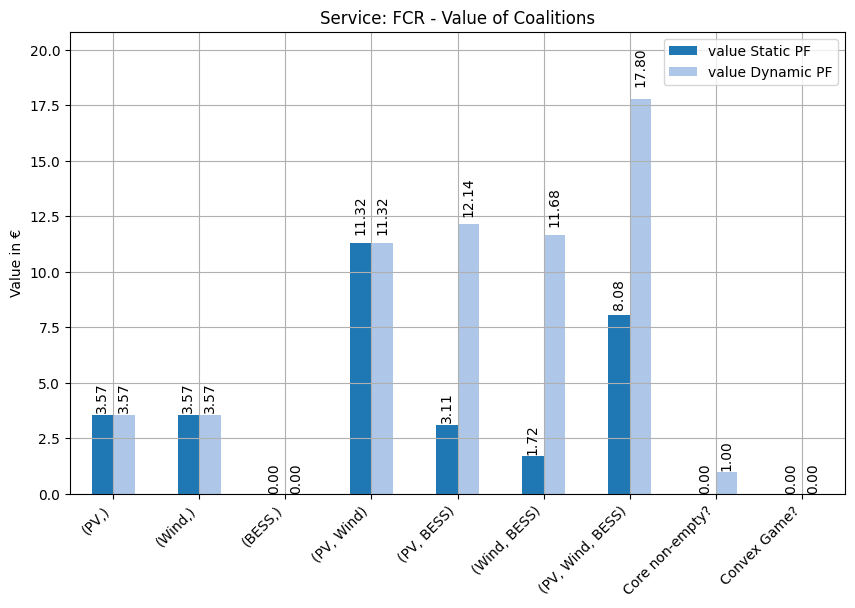

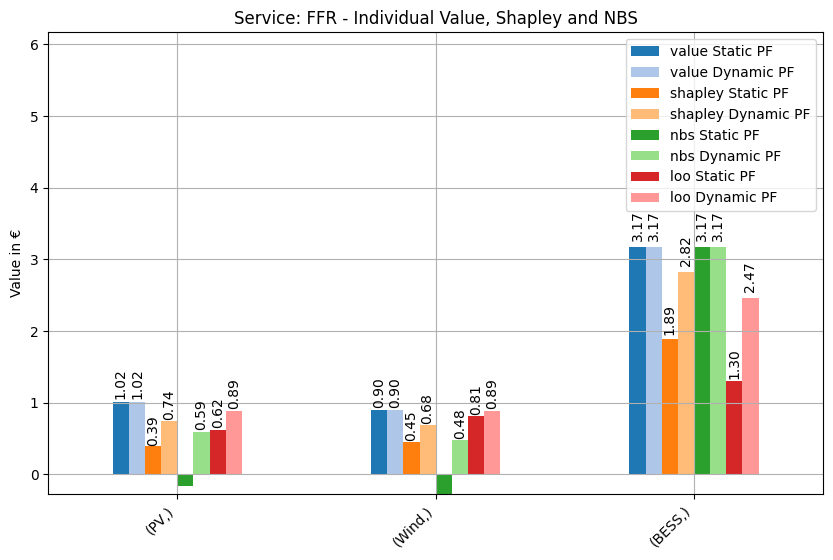

Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

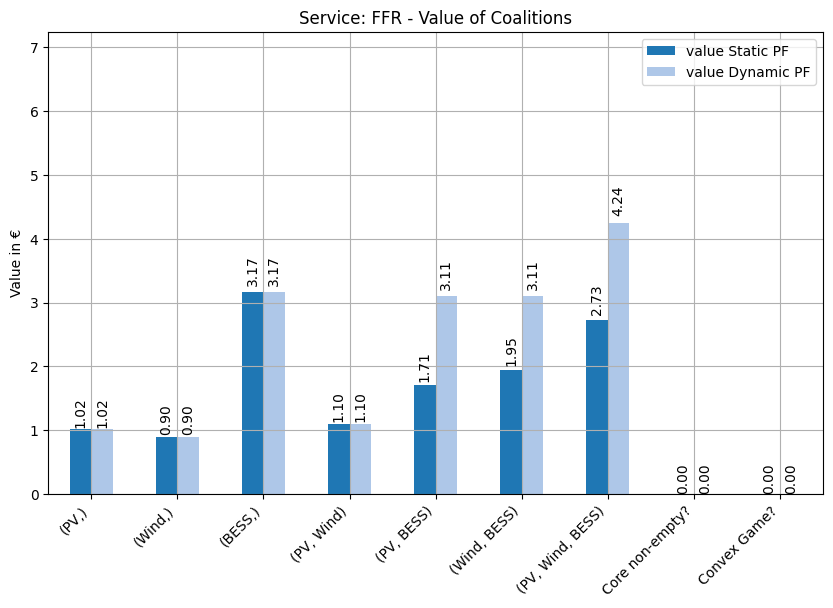

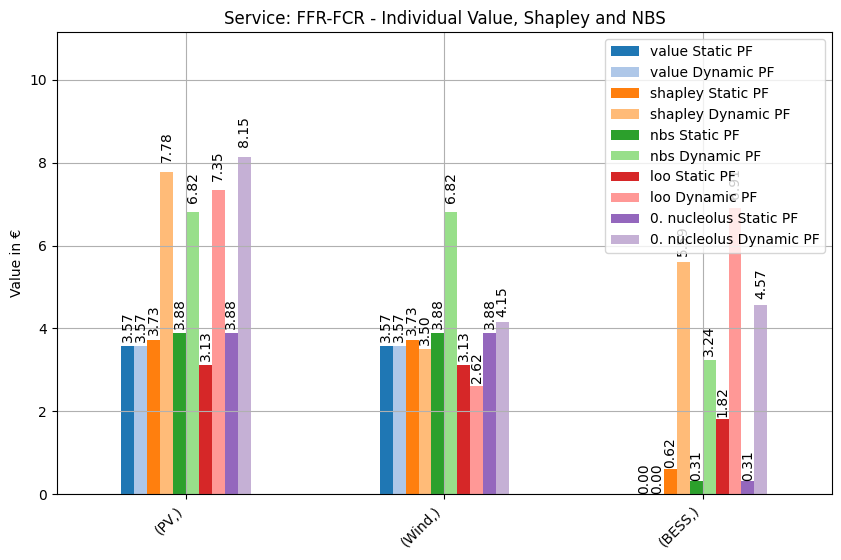

Core is non-empty, one feasible allocation: [3.57479 3.57479 9.72137]
Core is non-empty, one feasible allocation: [4.50064 3.57479 0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})
Game is not convex: frozenset({'PV'}), frozenset({'Wind'})


<Figure size 640x480 with 0 Axes>

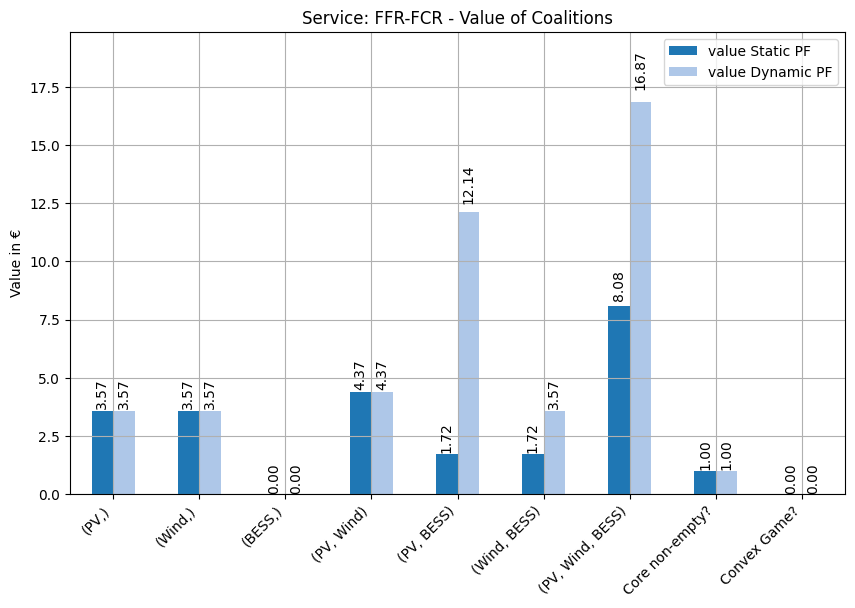

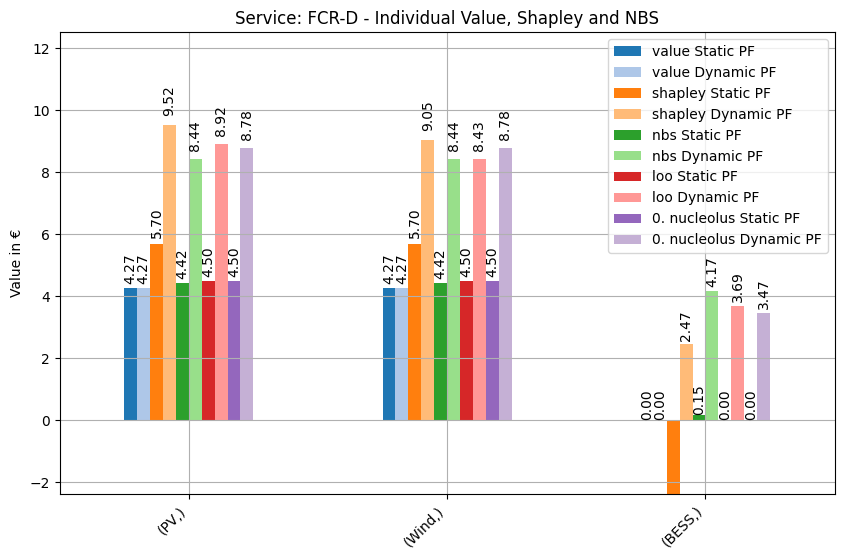

Core is non-empty, one feasible allocation: [16.76809  4.26917  0.     ]
Game is not convex: frozenset({'PV'}), frozenset({'BESS'})


<Figure size 640x480 with 0 Axes>

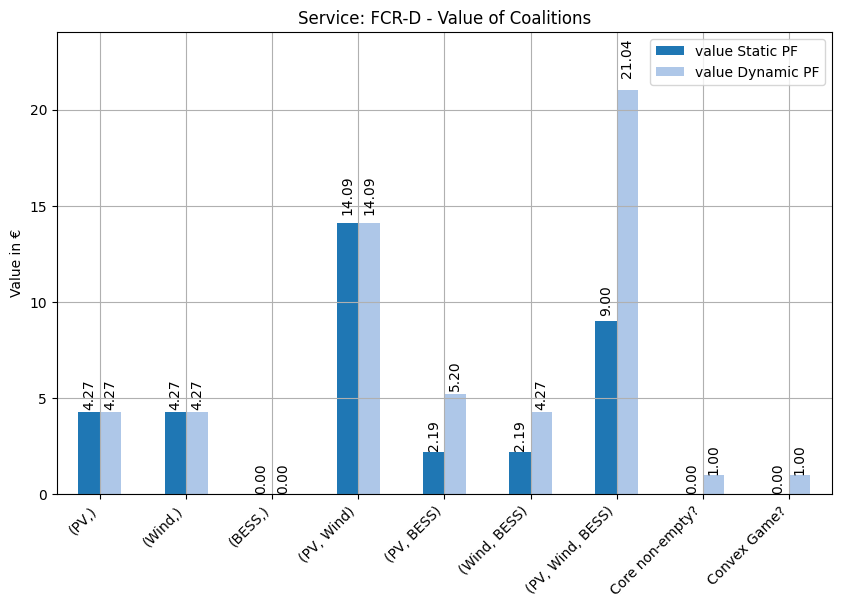

In [249]:
visualize_value_results(df_new, df_newstat)

## compare scenarios

### NBS

<Figure size 640x480 with 0 Axes>

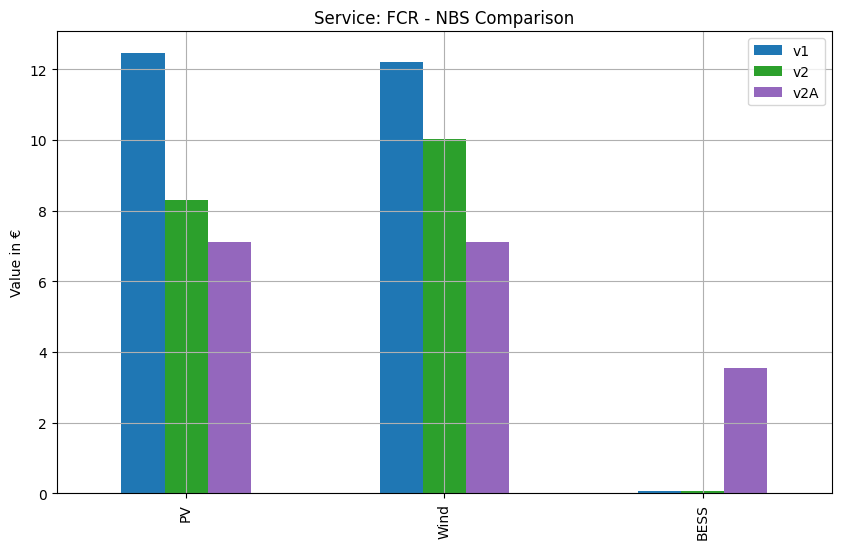

<Figure size 640x480 with 0 Axes>

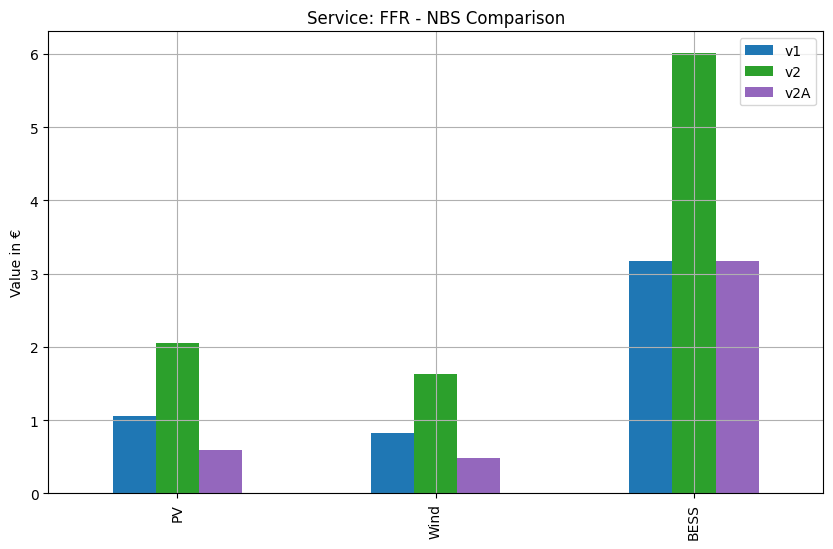

<Figure size 640x480 with 0 Axes>

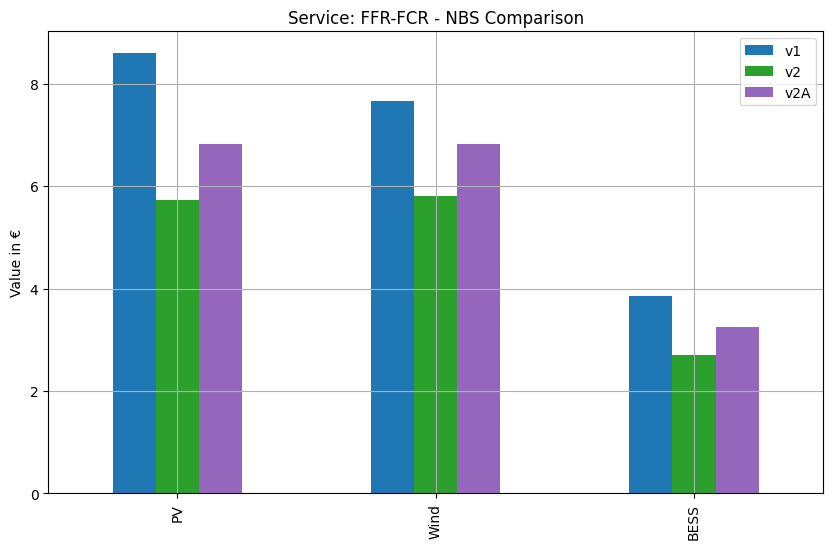

<Figure size 640x480 with 0 Axes>

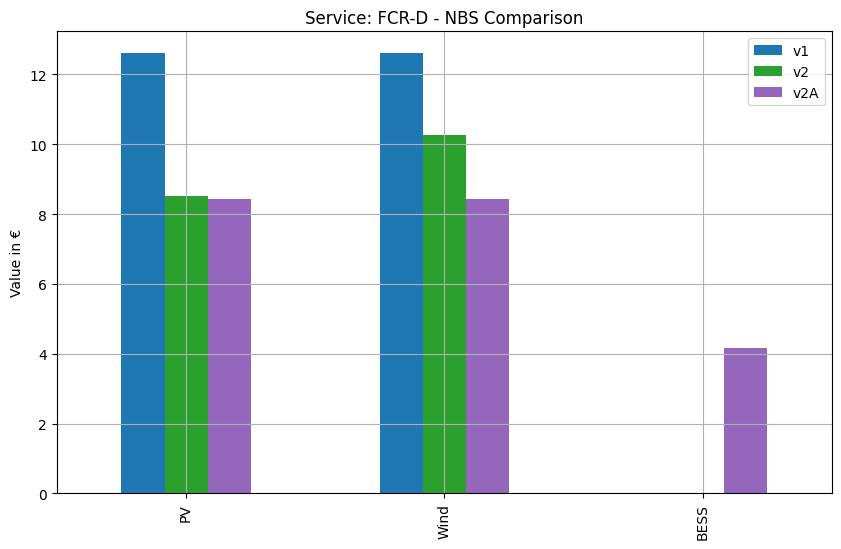

In [265]:
# NBS
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# get new colors
colors = plt.cm.tab20(np.linspace(0, .4, len(cases)))
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['nbs'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - NBS Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

### Nucleolus

C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values
C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values


Could not plot nucleolus for FFR in case v1: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v2: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FFR in case v2A: Length of values (0) does not match length of index (3)
Could not plot nucleolus for FCR-D in case v2: Length of values (0) does not match length of index (3)


C:\Users\carlv\AppData\Local\Temp\ipykernel_11520\1561283011.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_final.loc[:, cases[i]] = df_plot.values


<Figure size 640x480 with 0 Axes>

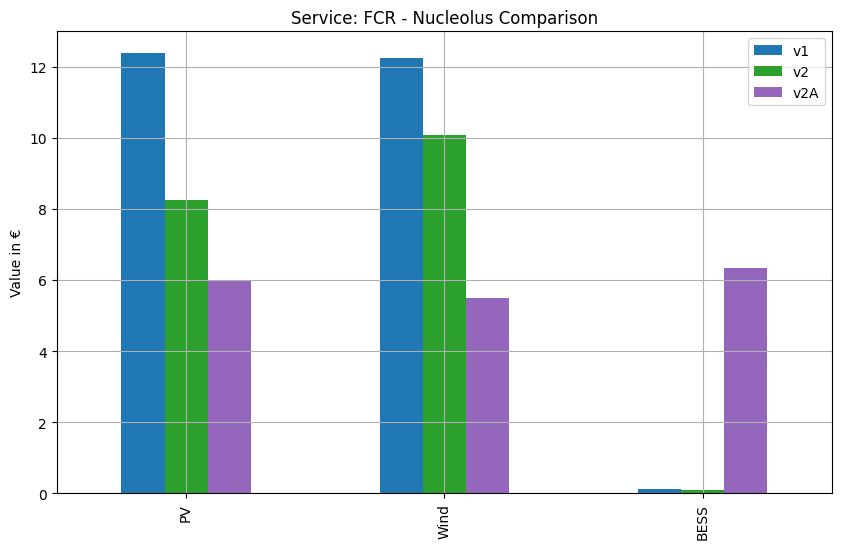

<Figure size 640x480 with 0 Axes>

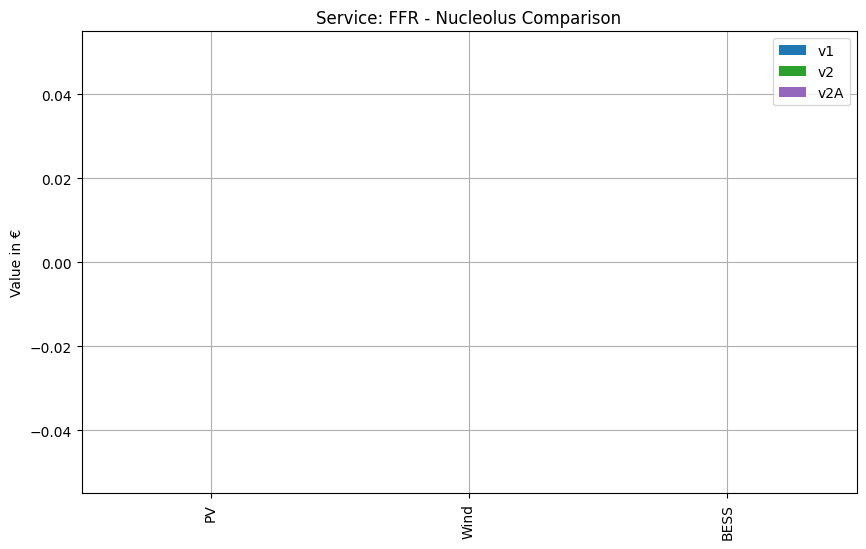

<Figure size 640x480 with 0 Axes>

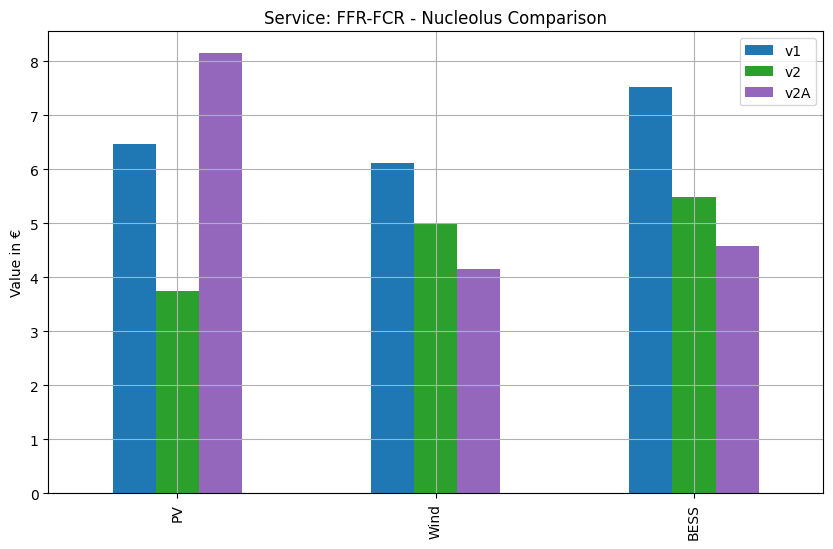

<Figure size 640x480 with 0 Axes>

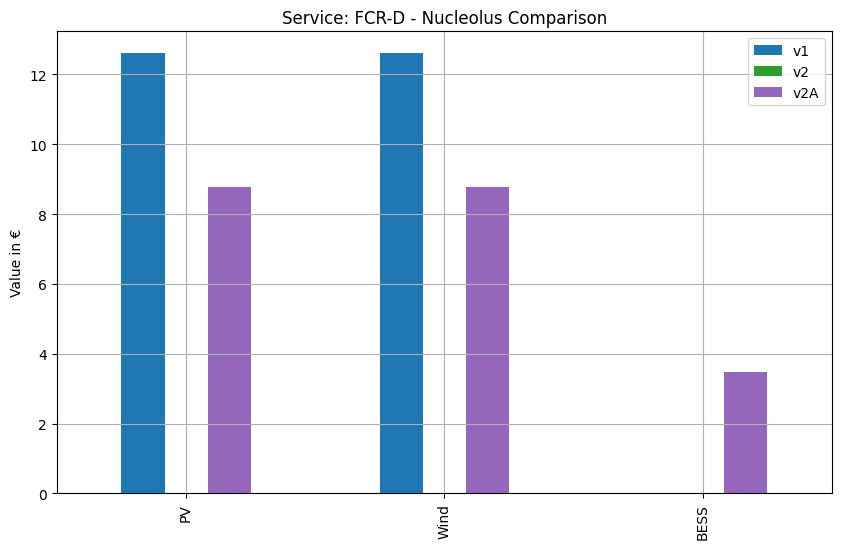

In [266]:
# compare Nucleolus
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        try:
            df_plot = df.loc[service].loc['0. nucleolus'].dropna().astype(float)
            df_final.loc[:, cases[i]] = df_plot.values
        except Exception as e:
            print(f"Could not plot nucleolus for {service} in case {cases[i]}: {e}")
            continue
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - Nucleolus Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()

### LOO

<Figure size 640x480 with 0 Axes>

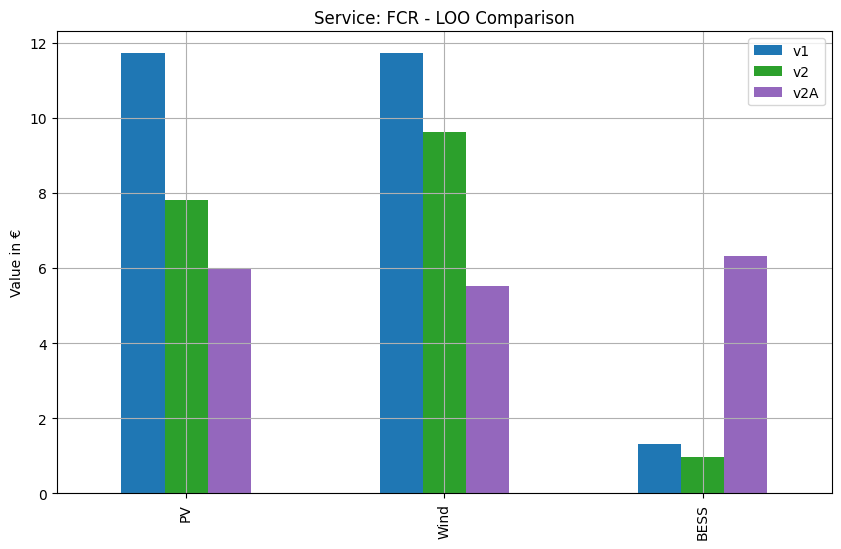

<Figure size 640x480 with 0 Axes>

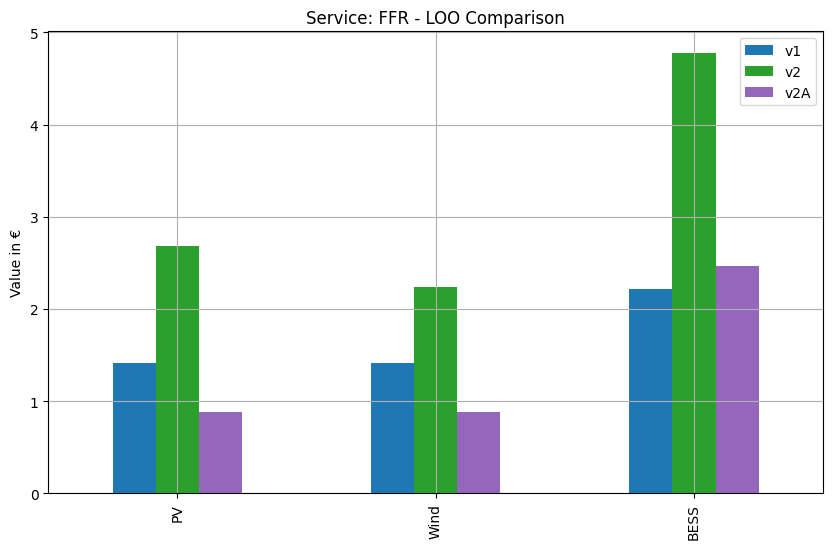

<Figure size 640x480 with 0 Axes>

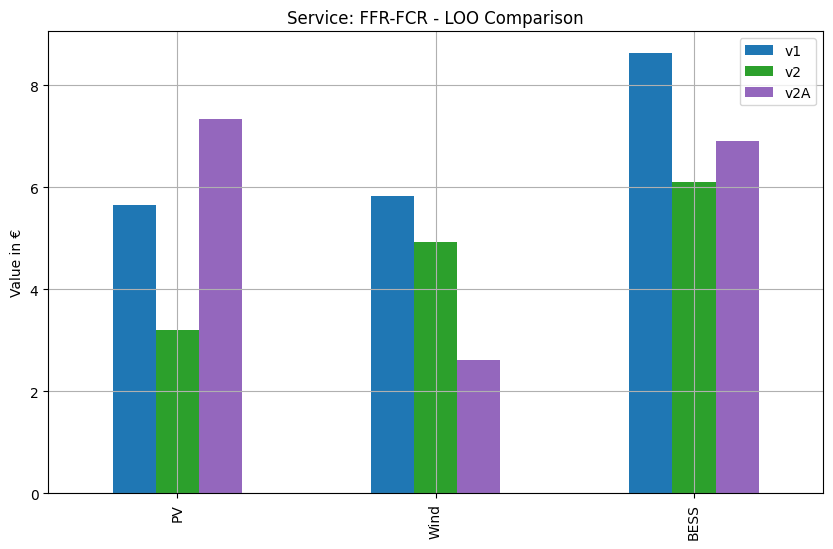

<Figure size 640x480 with 0 Axes>

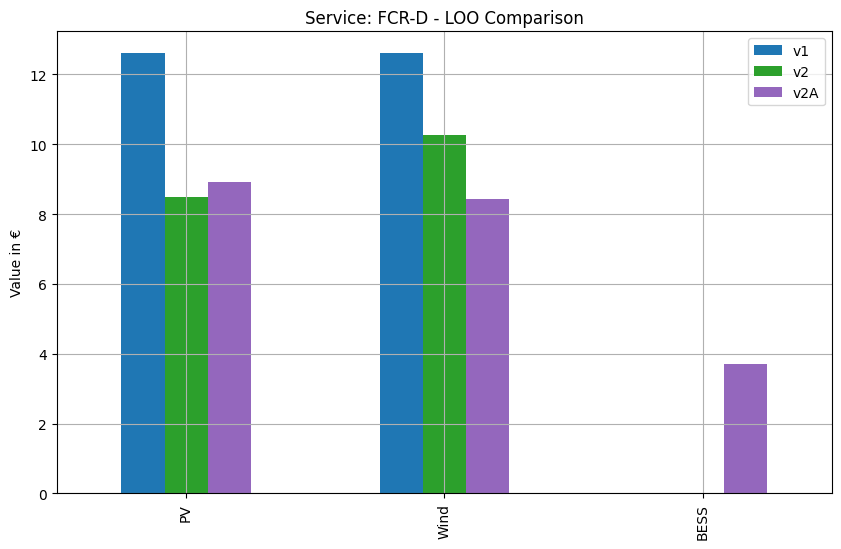

In [267]:
# compare LOO
dfs = [df_v1, df_v2, df_v2A]
cases = ['v1', 'v2', 'v2A']
names = [x[0] for x in df_v1.columns if len(x)==1]
# plot to compare shapely value
for service in df_v1.index.get_level_values(0).unique():
    plt.figure()
    df_final = pd.DataFrame(0, index=names, columns=cases, dtype=float)
    for i, df in enumerate(dfs):
        df_plot = df.loc[service].loc['loo'].dropna().astype(float)
        df_final.loc[:, cases[i]] = df_plot.values
    ax = df_final.plot(kind='bar', figsize=(10, 6),
                    title=f'Service: {service} - LOO Comparison', ylabel='Value in €',
                    color=colors)
    plt.grid()